In [2]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
print("OK ✅", pd.__version__, sklearn.__version__)

OK ✅ 2.3.3 1.6.1


# Laboratorio 1 — AlpesHearth

## 1. Carga de datos

In [3]:

TRAIN_PATH = "Datos Lab 1.csv"
TEST_PATH  = "Datos Test Lab 1.csv"       
TARGET_COL = "CVD Risk Score"    

df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH, sep=";")
data_copy = df.copy()
data_test_copy = df_test.copy()


## 2. Exploración y perfilamiento

### Unicidad 
los datos, revisaremos que no existan datos duplicados, que harian que nuestro modelo empiece a tomar tendencias que no deberia, todos estos registros duplicados los limpiearemos.

In [4]:
data_copy["_idx"] = data_copy.index

def choose_row(group):
    positives = group[group["CVD Risk Score"] >= 0]

    if not positives.empty:

        return positives.loc[positives["_idx"].idxmax()]
    else:

        return group.loc[group["_idx"].idxmax()]

unique_df = data_copy.groupby("Patient ID", group_keys=False).apply(choose_row)

duplicados = data_copy[~data_copy["_idx"].isin(unique_df["_idx"])]

duplicados = duplicados.assign(
    repeticiones=duplicados.groupby("Patient ID")["Patient ID"].transform("size")
).sort_values(["repeticiones", "Patient ID"], ascending=[False, True])

duplicados

C:\Users\Daniel\AppData\Local\Temp\ipykernel_33644\458371000.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_df = data_copy.groupby("Patient ID", group_keys=False).apply(choose_row)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level,_idx,repeticiones
17,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.9,139/61,253.0,...,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,16.770,HIGH,17,2
1227,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.9,139/61,253.0,...,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,-13.090,HIGH,1227,2
130,BQvQ6431,09/11/2020,M,33.0,118.300,1.690,41.400,72.1,116/93,171.0,...,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,17.500,LOW,130,2
1469,BQvQ6431,09/11/2020,M,33.0,118.300,1.690,41.400,72.1,116/93,171.0,...,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,29.833,LOW,1469,2
850,CDsa2651,23/06/2025,M,39.0,73.300,1.740,24.200,95.0,111/84,158.0,...,174.000,0.546,111.0,84.0,Hypertension Stage 1,91.0,26.604,INTERMEDIARY,850,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,yAIB3468,29 Jan 22,F,53.0,70.300,1.670,6.235,88.8,130/97,277.0,...,167.000,0.532,130.0,97.0,Hypertension Stage 1,187.0,17.080,HIGH,469,1
512,yAsk5000,01-09-2023,F,59.0,89.400,1.670,32.100,107.2,118/89,206.0,...,167.000,0.642,118.0,89.0,Hypertension Stage 1,122.0,18.440,HIGH,512,1
547,yvsn3005,28 Oct 20,F,60.0,54.300,1.810,16.600,99.1,133/65,187.0,...,181.000,0.548,133.0,65.0,Hypertension Stage 1,79.0,15.710,INTERMEDIARY,547,1
95,zcgB3048,12/06/2020,M,38.0,60.436,1.506,20.269,79.7,168/63,119.0,...,150.616,0.529,168.0,63.0,Hypertension Stage 2,43.0,14.834,HIGH,95,1


In [5]:
# Convertir la columna fecha a tipo datetime
data_copy['Date of Service'] = pd.to_datetime(
    data_copy['Date of Service'],
    format='mixed',
    dayfirst=False,
    errors='coerce'
)

# Ordenar por ID y fecha (más reciente primero)
data_copy = data_copy.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])

# Función con tu criterio: positivos primero, y dentro de ellos el más reciente
def select_record(group):
    positives = group[group['CVD Risk Score'] >= 0]

    if not positives.empty:
        # Si hay positivos → tomar el más reciente (ya está ordenado)
        return positives.iloc[0]
    else:
        # Si todos son negativos → también tomar el más reciente
        return group.iloc[0]

# Aplicar la selección por Patient ID
data_copy = data_copy.groupby('Patient ID', group_keys=False).apply(select_record)

# Resetear índice limpio (opcional)
data_copy = data_copy.reset_index(drop=True)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_33644\781059742.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_copy = data_copy.groupby('Patient ID', group_keys=False).apply(select_record)


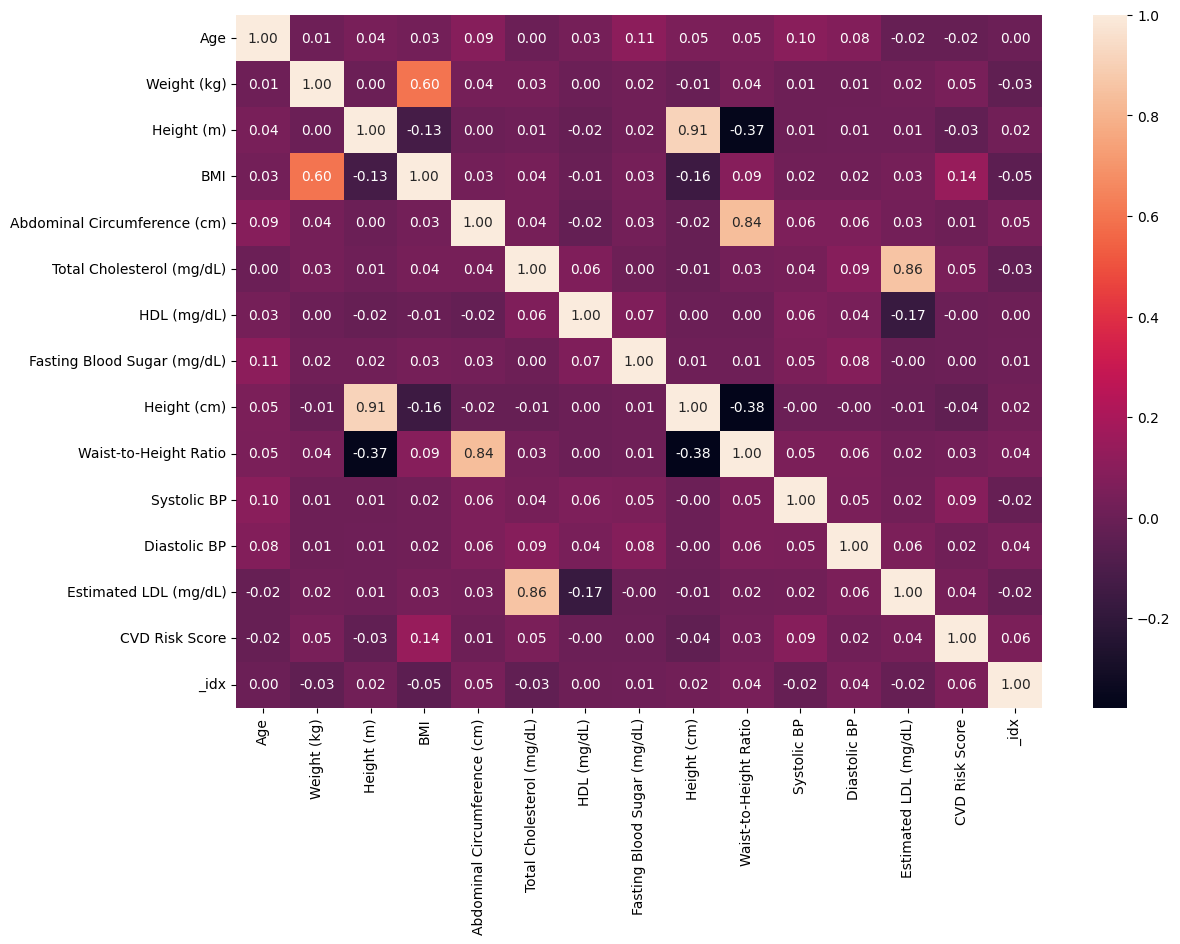

In [6]:
plt.figure(figsize=(13, 9))  # ancho x alto en pulgadas
sns.heatmap(data_copy.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()


Vemos que aun tenemos muchos valores en NULL, esto nos afecta porque nuestro modelo no podra estar bien ajustado y tendremos que corregir estos datos. 

In [7]:
data_copy['Height (cm)'] = data_copy['Height (cm)'].fillna(data_copy['Height (m)'] * 100)
data_copy = data_copy[~(data_copy['Height (cm)'].isna() & data_copy['Height (m)'].isna())]

# RECONSTRUIR BMI = weight_kg / (height_m^2)
data_copy['height_m_temp'] = data_copy['Height (cm)'] / 100

data_copy['BMI'] = data_copy['BMI'].fillna(data_copy['Weight (kg)'] / (data_copy['height_m_temp'] ** 2))

data_copy = data_copy[~(data_copy['BMI'].isna())]

data_copy['Waist-to-Height Ratio'] = data_copy['Waist-to-Height Ratio'].fillna(
    data_copy['Abdominal Circumference (cm)'] / data_copy['Height (cm)']
)

data_copy = data_copy[~data_copy['Waist-to-Height Ratio'].isna()]

data_copy = data_copy.drop(columns=[ 'height_m_temp'], errors='ignore')

def split_bp(value):
    if isinstance(value, str) and "/" in value:
        sys, dia = value.split("/")
        return float(sys), float(dia)
    return (None, None)

data_copy[['BP_sys', 'BP_dia']] = data_copy['Blood Pressure (mmHg)'].apply(
    lambda x: pd.Series(split_bp(x))
)

data_copy['Systolic BP'] = data_copy['Systolic BP'].fillna(data_copy['BP_sys'])
data_copy['Diastolic BP'] = data_copy['Diastolic BP'].fillna(data_copy['BP_dia'])

data_copy = data_copy.drop(columns=['BP_sys', 'BP_dia'])

data_test_copy[['BP_sys', 'BP_dia']] = data_test_copy['Blood Pressure (mmHg)'].apply(
    lambda x: pd.Series(split_bp(x))
)

data_test_copy['Systolic BP'] = data_test_copy['Systolic BP'].fillna(data_test_copy['BP_sys'])
data_test_copy['Diastolic BP'] = data_test_copy['Diastolic BP'].fillna(data_test_copy['BP_dia'])

data_test_copy = data_test_copy.drop(columns=['BP_sys', 'BP_dia'])

data_copy['Weight (kg)'] = data_copy['Weight (kg)'].fillna(
    data_copy['BMI'] * (data_copy['Height (cm)'] / 100) ** 2
)
data_copy['Weight (kg)'] = data_copy['Weight (kg)'].fillna(
    data_copy['Weight (kg)'].median()
)

data_copy['HDL (mg/dL)'] = data_copy['HDL (mg/dL)'].fillna(
    data_copy['HDL (mg/dL)'].median()
)

data_copy['Age'] = data_copy['Age'].fillna(data_copy['Age'].median())

data_copy['Total Cholesterol (mg/dL)'] = data_copy['Total Cholesterol (mg/dL)'].fillna(
    data_copy['Total Cholesterol (mg/dL)'].median()
)

data_copy['Abdominal Circumference (cm)'] = data_copy['Abdominal Circumference (cm)'].fillna(
    data_copy['Waist-to-Height Ratio'] * data_copy['Height (cm)']
)
data_copy['Abdominal Circumference (cm)'] = data_copy['Abdominal Circumference (cm)'].fillna(
    data_copy['Abdominal Circumference (cm)'].median()
)

data_copy['Fasting Blood Sugar (mg/dL)'] = data_copy['Fasting Blood Sugar (mg/dL)'].fillna(
    data_copy['Fasting Blood Sugar (mg/dL)'].median()
)

data_copy['Estimated LDL (mg/dL)'] = data_copy['Estimated LDL (mg/dL)'].fillna(
    data_copy['Estimated LDL (mg/dL)'].median()
)

data_copy = data_copy.dropna(subset=['CVD Risk Score'])

((data_copy.isnull().sum()/data_copy.shape[0])).sort_values(ascending=False)


Height (m)                      0.033482
Patient ID                      0.000000
Diabetes Status                 0.000000
CVD Risk Level                  0.000000
CVD Risk Score                  0.000000
Estimated LDL (mg/dL)           0.000000
Blood Pressure Category         0.000000
Diastolic BP                    0.000000
Systolic BP                     0.000000
Waist-to-Height Ratio           0.000000
Height (cm)                     0.000000
Family History of CVD           0.000000
Physical Activity Level         0.000000
Smoking Status                  0.000000
Date of Service                 0.000000
Fasting Blood Sugar (mg/dL)     0.000000
HDL (mg/dL)                     0.000000
Total Cholesterol (mg/dL)       0.000000
Blood Pressure (mmHg)           0.000000
Abdominal Circumference (cm)    0.000000
BMI                             0.000000
Weight (kg)                     0.000000
Age                             0.000000
Sex                             0.000000
_idx            

### Consistencia
Miramos que todos los datos que tenemos, vengan con el formato que se nos indica

Primero vemos los valores que no son numericos

In [8]:
print(data_copy["Sex"].value_counts(dropna=False))
print(" ")
print(data_copy["Smoking Status"].value_counts(dropna=False))
print(" ")
print(data_copy["Diabetes Status"].value_counts(dropna=False))
print(" ")
print(data_copy["Physical Activity Level"].value_counts(dropna=False))
print(" ")
print(data_copy["Family History of CVD"].value_counts(dropna=False))
print(" ")
print(data_copy["Blood Pressure Category"].value_counts(dropna=False))

Sex
F    676
M    668
Name: count, dtype: int64
 
Smoking Status
Y    691
N    653
Name: count, dtype: int64
 
Diabetes Status
Y    679
N    665
Name: count, dtype: int64
 
Physical Activity Level
High        462
Moderate    449
Low         433
Name: count, dtype: int64
 
Family History of CVD
N    685
Y    659
Name: count, dtype: int64
 
Blood Pressure Category
Hypertension Stage 2    554
Hypertension Stage 1    439
Normal                  262
Elevated                 89
Name: count, dtype: int64


Ahora miramos si los datos numericos

In [9]:
for col in data_copy.select_dtypes(include=["int64", "float64"]).columns:
    not_numeric = pd.to_numeric(data_copy[col], errors="coerce").isna()
    invalid_count = not_numeric.sum()
    print(f"{col}: valores NO numéricos = {invalid_count}")

Age: valores NO numéricos = 0
Weight (kg): valores NO numéricos = 0
Height (m): valores NO numéricos = 45
BMI: valores NO numéricos = 0
Abdominal Circumference (cm): valores NO numéricos = 0
Total Cholesterol (mg/dL): valores NO numéricos = 0
HDL (mg/dL): valores NO numéricos = 0
Fasting Blood Sugar (mg/dL): valores NO numéricos = 0
Height (cm): valores NO numéricos = 0
Waist-to-Height Ratio: valores NO numéricos = 0
Systolic BP: valores NO numéricos = 0
Diastolic BP: valores NO numéricos = 0
Estimated LDL (mg/dL): valores NO numéricos = 0
CVD Risk Score: valores NO numéricos = 0
_idx: valores NO numéricos = 0


### Validez

In [10]:
data_copy.describe()

,Date of Service,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score,_idx
count,1344,1344.000000,1344.000000,1299.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,2022-12-07 05:53:34.285714432,47.016981,85.874641,1.756128,28.535779,91.938961,198.093964,56.132400,117.009764,175.561473,0.524899,125.594718,82.915733,112.094702,18.176673,782.470238
min,2020-01-02 00:00:00,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000,0.000000
25%,2021-05-27 00:00:00,37.000000,67.042750,1.665000,22.500000,80.300000,152.000000,42.000000,92.000000,166.778000,0.457000,108.000000,71.000000,63.000000,15.150000,361.750000
50%,2022-11-08 12:00:00,46.000000,86.484000,1.760000,28.177000,91.600000,197.000000,56.000000,115.000000,176.000000,0.521000,125.000000,82.000000,110.000000,16.940000,766.500000
75%,2024-07-14 06:00:00,55.000000,104.637000,1.850000,34.100000,102.465750,247.000000,69.000000,138.000000,184.658750,0.583250,141.000000,94.000000,157.000000,18.825750,1199.250000
max,2025-12-30 00:00:00,89.420000,158.523000,2.146000,58.510898,136.336000,385.679000,110.315000,219.667000,214.394000,0.825281,202.711000,134.066000,317.314000,114.980000,1638.000000
std,NaN,12.613586,21.790350,0.117990,7.431246,13.361906,58.197582,16.295997,31.452446,11.714691,0.085213,22.703142,15.583117,60.653981,10.889689,476.127503


Vemos que la variable objetivo tiene datos que no tienen sentido, como negativos y algunos que se salen del rango, los negativos los tomaremos como valor absoluto porque pudieron ser registrados de manera incorrecta, pero en su valor normal pueden ayudar al modelo con mas informacion, pero los valores fuera de un rango normal (0-100) es mejor eliminarlos ya que imputarlos con la media o algun otro valor, puede generar malos resultados en nuestro modelo. 

In [11]:
data_copy["CVD Risk Score"] = data_copy["CVD Risk Score"].abs()

# Eliminar registros con CVD Risk Score inválido
data_copy = data_copy[
    (data_copy["CVD Risk Score"] >= 0) &
    (data_copy["CVD Risk Score"] <= 100)
].copy()

data_copy["CVD Risk Score"].describe()

count    1334.000000
mean       17.629041
std         7.212355
min         0.883000
25%        15.168500
50%        16.920500
75%        18.779500
max        99.775000
Name: CVD Risk Score, dtype: float64

Variables descriptivas

In [12]:
data_copy = data_copy[
    (data_copy["Total Cholesterol (mg/dL)"] >= 0) &
    (data_copy["Estimated LDL (mg/dL)"] >= 0) &
    (data_copy["Fasting Blood Sugar (mg/dL)"] >= 40) &
    (data_copy["Systolic BP"] >= 70) &
    (data_copy["Diastolic BP"] >= 40) 
].copy()

## 3. Preparación de datos

In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1) Eliminar filas donde el target esté vacío (NO se imputa el target)
print("Filas antes:", df.shape)
df = df.dropna(subset=[TARGET_COL]).copy()
print("Filas después:", df.shape)

# 2) Trabajar SIEMPRE sobre copias (actualizadas)
data_copy = df.copy()
data_test_copy = df_test.copy()   # <-- en tu notebook el test se llama df_test

# (Opcional) Conteo de nulos para justificar decisiones
data_copy.isna().sum().sort_values(ascending=False)

# 3) Eliminar columnas que no deben entrar al modelo
cols_to_drop = [
    "Patient ID",
    "Date of Service",
    "CVD Risk Level",
    "Height (m)"
]

data_copy = data_copy.drop(columns=cols_to_drop, errors="ignore")
data_test_copy = data_test_copy.drop(columns=cols_to_drop, errors="ignore")

# 4) Separar X/y (DESDE data_copy, no desde df)
X = data_copy.drop(columns=[TARGET_COL], errors="ignore")
y = data_copy[TARGET_COL]

# 5) Split obligatorio (según enunciado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("X_train, X_test:", X_train.shape, X_test.shape)
print("Nulos en y_train:", y_train.isna().sum(), "| Nulos en y_test:", y_test.isna().sum())

# 6) Identificar numéricas / categóricas
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# 7) Pipelines de transformación
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 8) Preprocessor final
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder="drop"
)

# (Mini-check) confirmar que cols_to_drop NO están en X_train
print("Cols_to_drop presentes en X_train?:",
      set(cols_to_drop).intersection(set(X_train.columns)))


Filas antes: (1639, 24)
Filas después: (1610, 24)
X_train, X_test: (1207, 19) (403, 19)
Nulos en y_train: 0 | Nulos en y_test: 0
Numéricas: ['Age', 'Weight (kg)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Blood Pressure (mmHg)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']
Cols_to_drop presentes en X_train?: set()


## 4. Modelos (2 pipelines)

In [134]:
model_1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)


mse_1 = mean_squared_error(y_test, y_pred_1)
rmse_1 = np.sqrt(mse_1)
mae_1 = mean_absolute_error(y_test, y_pred_1)
r2_1 = r2_score(y_test, y_pred_1)

print("Modelo 1 - LinearRegression")
print("RMSE:", rmse_1)
print("MAE:", mae_1)
print("R2:", r2_1)

model_2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0, random_state=42))
])

model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)

mse_2 = mean_squared_error(y_test, y_pred_2)
rmse_2 = np.sqrt(mse_2)
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

print("\nModelo 2 - Ridge")
print("RMSE:", rmse_2)
print("MAE:", mae_2)
print("R2:", r2_2)



Modelo 1 - LinearRegression
RMSE: 10.51965394046974
MAE: 4.310109473095466
R2: 0.02021218032221117

Modelo 2 - Ridge
RMSE: 10.278652634360203
MAE: 4.204393602135459
R2: 0.06459107705757872


## 5. Tabla comparativa (RMSE/MAE/R2)

In [135]:
import pandas as pd

results = pd.DataFrame({
    "Modelo": ["LinearRegression", "Ridge"],
    "RMSE": [rmse_1, rmse_2],
    "MAE": [mae_1, mae_2],
    "R2": [r2_1, r2_2]
})

results


,Modelo,RMSE,MAE,R2
0,LinearRegression,10.519654,4.310109,0.020212
1,Ridge,10.278653,4.204394,0.064591


## 6. Interpretación e importancia de variables

In [136]:
# Obtener nombres de las variables después del preprocesamiento
feature_names = model_2.named_steps["preprocessor"].get_feature_names_out()


In [137]:
coefficients = model_2.named_steps["regressor"].coef_

coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente": coefficients
})

coef_df = coef_df.sort_values(by="Coeficiente", key=abs, ascending=False)
coef_df.head(10)


,Variable,Coeficiente
2550,cat__Blood Pressure (mmHg)_139/64,26.010250
968,cat__Patient ID_vmHe7241,26.010250
1211,cat__Date of Service_06-04-2020,23.551649
443,cat__Patient ID_UhjR9901,23.551649
2083,cat__Blood Pressure (mmHg)_102/90,23.551649
1233,cat__Date of Service_06/03/2022,22.771122
115,cat__Patient ID_FMVb4279,22.771122
2138,cat__Blood Pressure (mmHg)_106/83,22.771122
379,cat__Patient ID_RWyR9287,22.639718
2350,cat__Blood Pressure (mmHg)_123/72,22.639718


## 7. Respuestas “Análisis de resultados”
Los resultados obtenidos a partir de los dos modelos de regresión entrenados (Linear Regression y Ridge Regression) muestran un desempeño limitado en la predicción del CVD Risk Score. En ambos casos, los valores de RMSE y MAE son relativamente similares, lo que indica que el error promedio de las predicciones se mantiene estable entre los dos modelos.

El modelo de Ridge Regression presenta una ligera mejora frente a la regresión lineal simple, reflejada en un menor RMSE y MAE, así como en un valor de R² ligeramente superior. Esto sugiere que la regularización ayuda a reducir el sobreajuste y a estabilizar los coeficientes del modelo, especialmente en presencia de variables correlacionadas.

Sin embargo, el valor de R² es bajo en ambos modelos, lo que indica que solo una pequeña proporción de la variabilidad del riesgo cardiovascular es explicada por las variables utilizadas. Esto sugiere que la relación entre las variables clínicas y el CVD Risk Score no es estrictamente lineal o que existen factores adicionales no incluidos en el conjunto de datos que influyen de manera significativa en el riesgo cardiovascular.

Es importante destacar que este resultado no implica un error en la implementación del modelo, sino que refleja las limitaciones inherentes al enfoque lineal y a la información disponible. A pesar de ello, el uso de pipelines permitió garantizar un flujo de trabajo correcto, evitando la fuga de información y asegurando que el preprocesamiento se aplicara únicamente a los datos de entrenamiento.

Como posible mejora futura, se podrían explorar modelos no lineales, como árboles de decisión o métodos basados en ensambles, así como la incorporación de nuevas variables clínicas o derivadas, con el fin de capturar relaciones más complejas entre los factores de riesgo y el puntaje cardiovascular.

## 8. Predicciones en test no etiquetado

## 9. Uso de herramientas de IA generativa